In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import fitsio
import os
from desitarget.targetmask import desi_mask, obsconditions
from sklearn.neighbors import NearestNeighbors

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
MEDIUM_SIZE = 30
SMALL_SIZE = 22
SSSMALL_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)
os.environ['PATH'] = '/global/common/sw/cray/sles15/x86_64/texlive/live/gcc/8.2.0/tiozj27/bin/x86_64-linux/:{}'.format(os.environ['PATH'])

In [3]:
no_petal = True

In [4]:
if no_petal:
    targetdata = fitsio.read("summary_dr9/fba_summary_dark_full_dr9_nopetal_3.fits", 
                             columns=["RA", "DEC", "NUMOBS", "isELG", "isLRG", "isQSO"])
else:
    targetdata = fitsio.read("summary_dr9/fba_summary_dark_full_dr9.fits", 
                             columns=["RA", "DEC", "NUMOBS", "isELG", "isLRG", "isQSO"])

In [5]:
isin = (targetdata['RA']>180) & (targetdata['RA']<210) & (targetdata['DEC']>0) & (targetdata['DEC']<10)
print(np.count_nonzero(isin))
targetdata = targetdata[isin]
is_science = targetdata['isQSO']|targetdata['isLRG']|targetdata['isELG']

1360541


In [6]:
ii = (targetdata['NUMOBS']>0)  
print(np.count_nonzero(ii), np.count_nonzero(ii)/len(targetdata))

679449 0.4993961960720037


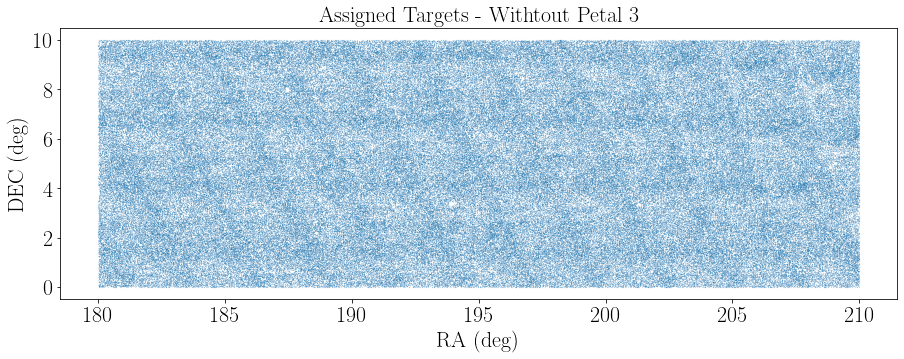

In [7]:
n = len(targetdata)
r = np.random.random(n)
ii = r<0.5
jj = (targetdata['NUMOBS']>0)
plt.figure(figsize=(15,5))
plt.scatter(targetdata['RA'][jj&ii&is_science], targetdata['DEC'][jj&ii&is_science], s=0.03, alpha=0.5)
plt.xlabel("RA (deg)")
plt.ylabel("DEC (deg)")
if no_petal:
    plt.title("Assigned Targets - Withtout Petal 3")
    filename = "DR9_scatter_nopetal_3.png"
else:
    plt.title("Assigned Targets - All Petals")
    filename = "DR9_scatter.png"
plt.savefig(filename, bbox_inches='tight')

In [8]:
theta = np.deg2rad(90.0 - targetdata['DEC'])
phi = np.deg2rad(targetdata['RA'])
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)
data = np.array([x,y,z])
data = data.T
neighbors = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(data)
dist, ind = neighbors.kneighbors(data)

In [9]:
jj = (targetdata['NUMOBS']>0)
theta = np.deg2rad(90.0 - targetdata['DEC'][jj])
phi = np.deg2rad(targetdata['RA'][jj])
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)
data_obs = np.array([x,y,z])
data_obs = data_obs.T
neighbors_obs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(data_obs)
dist_obs, ind_obs = neighbors.kneighbors(data_obs)

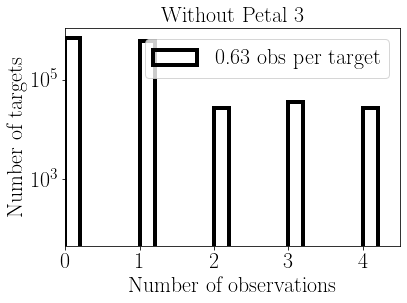

In [10]:
_= plt.hist(targetdata['NUMOBS'],
           histtype='step', density=False, bins=np.arange(0,6,0.2), linewidth=4, color='black', log=True, 
           label='{:.2f} obs per target'.format(np.mean(targetdata['NUMOBS'])))

plt.xlabel("Number of observations")
plt.ylabel("Number of targets")

_ = plt.xticks(ticks=np.arange(10))
plt.xlim([0,4.5])
plt.legend()
if no_petal:
    filename = "DR9_numobs_nopetal_3.png"
    plt.title("Without Petal 3")
else:
    filename = "DR9_numobs.png"
    plt.title("All petals")

plt.savefig(filename, bbox_inches='tight')

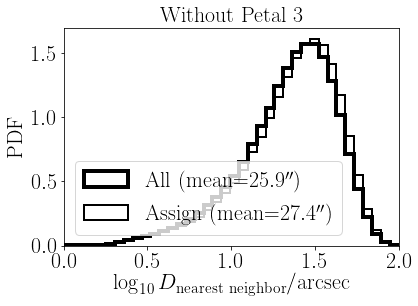

In [11]:
_=plt.hist(np.log10(np.rad2deg(dist[:,1])*3600.0), 
           histtype='step', density=True, bins=100, 
           label='All (mean=${:.1f}'.format(np.mean(np.rad2deg(dist[:,1])*3600.0))+'^{\prime\prime}$)',
           linewidth=4, color='black')
_=plt.hist(np.log10(np.rad2deg(dist_obs[:,1])*3600.0), 
           histtype='step', density=True, bins=100,
          label='Assign (mean=${:.1f}'.format(np.mean(np.rad2deg(dist_obs[:,1])*3600.0))+'^{\prime\prime}$)',
           linewidth=2, color='black')
plt.xlabel("$\log_{10}  D_{\mathrm{nearest\ neighbor}} / \mathrm{arcsec}$")
plt.ylabel("PDF")
plt.legend(loc=3)

_ = plt.xticks(ticks=np.arange(0,2.2,0.5))
plt.xlim([0,2.0])
if no_petal:
    filename = "DR9_dnearest_nopetal_3.png"
    plt.title("Without Petal 3")
else:
    filename = "DR9_dnearest.png"
    plt.title("All petals")

plt.savefig(filename, bbox_inches='tight')

In [12]:
d_arcmin = np.rad2deg(dist)*60
in_patrol_radius = d_arcmin<1.0
n_in_patrol_radius = np.count_nonzero(in_patrol_radius, axis=1)


d_arcmin_obs = np.rad2deg(dist_obs)*60
in_patrol_radius_obs = d_arcmin_obs<1.0
n_in_patrol_radius_obs = np.count_nonzero(in_patrol_radius_obs, axis=1)

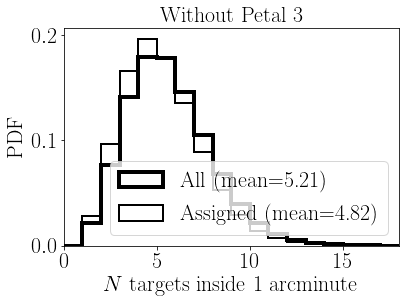

In [13]:
isobs = (targetdata['NUMOBS']>0)
_=plt.hist(n_in_patrol_radius, 
           histtype='step', density=True, bins=np.arange(30), 
           label='All (mean={:.2f})'.format(np.mean(n_in_patrol_radius)), linewidth=4, color='black')
_=plt.hist(n_in_patrol_radius_obs, 
           histtype='step', density=True, bins=np.arange(30), 
           label='Assigned (mean={:.2f})'.format(np.mean(n_in_patrol_radius_obs)), linewidth=2, color='black')
plt.xlabel("$N$ targets inside 1 arcminute")
plt.ylabel("PDF")
plt.legend(loc=4)

_ = plt.xticks(ticks=np.arange(0,30,5))
plt.xlim([0,18.0])
if no_petal:
    filename = "DR9_ninside_nopetal_3.png"
    plt.title("Without Petal 3")
else:
    filename = "DR9_ninside.png"
    plt.title("All Petals")
plt.savefig(filename, bbox_inches='tight')